<a href="https://colab.research.google.com/github/t0mm4rx/DataCrunchHackathon/blob/master/DataCrunch_Hackathon_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install catboost

     |████████████████████████████████| 66.2MB 68kB/s 


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
import catboost
from sklearn.decomposition import PCA
pd.set_option('display.max_columns', None)  

In [ ]:
train_url = '-'
test_url = '-'

train_before = pd.read_pickle(train_url)
test_before = pd.read_pickle(test_url)
train_before.head()

,Feature_1_cv_enum,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,Feature_11,Feature_12,Feature_13,Feature_14_cv_bool,Feature_15_cv_bool,Feature_16_cv_bool,Feature_17_cv_bool,Feature_18_adv_cv_bool,Feature_19_adv_cv_bool,Feature_20_adv_cv_bool,Feature_21_adv_cv_bool,Feature_22_adv_cv_bool,Feature_23_adv_cv_enum,target_r,target_g,target_b
82247,3.0,387.0,19527.0000,387,0.0000,387,38.699520,2734.620117,-0.189790,0.00,6.149803e+05,0.019819,0,1,0,0,0,0,0,0,0,1,4,1,0,1
143444,3.0,424.0,35489.4999,424,0.0000,424,NaN,NaN,NaN,0.00,4.167333e+06,0.011947,1,1,0,0,0,0,0,0,0,1,4,0,0,0
183844,3.0,253.0,243052.5175,253,0.0000,253,66.548996,2362.719971,0.129491,0.00,1.976974e+07,0.001041,1,1,0,0,0,0,0,0,0,1,4,0,0,0
156433,2.0,1526.0,111029.6685,1526,0.0000,1526,35.044918,2383.120117,0.205257,0.00,5.241259e+06,0.013744,1,0,1,0,0,1,0,0,1,0,0,0,0,0
44639,3.0,50.0,9380.2130,50,15.6942,50,NaN,NaN,NaN,784.71,1.330630e+05,0.005330,1,1,0,0,0,0,0,0,0,1,4,1,1,1


In [ ]:
train = train_before.copy()
test = test_before.copy()

for c in train.columns:
    if ("enum" in c):
        dummies = pd.get_dummies(train[c], prefix=c)
        train.drop(columns=[c], inplace=True)
        train = pd.concat([dummies, train], axis=1)

for c in test.columns:
    if ("enum" in c):
        dummies = pd.get_dummies(test[c], prefix=c)
        test.drop(columns=[c], inplace=True)
        test = pd.concat([dummies, test], axis=1)

for c in train.columns:
    train[c] = train[c].fillna(train[c].mean())
    train[c] = train[c].clip(
        train[c].quantile(0.01),
        train[c].quantile(0.99)
    )
    if (not "target" in c):
        test[c] = test[c].fillna(train[c].mean())
        test[c] = test[c].clip(
            train[c].quantile(0.01),
            train[c].quantile(0.99)
        )
        train[c] -= train[c].mean()
        train[c] /= train[c].std()

In [ ]:
train.head()

,Feature_23_adv_cv_enum_0,Feature_23_adv_cv_enum_1,Feature_23_adv_cv_enum_2,Feature_23_adv_cv_enum_3,Feature_23_adv_cv_enum_4,Feature_1_cv_enum_0.0,Feature_1_cv_enum_1.0,Feature_1_cv_enum_2.0,Feature_1_cv_enum_3.0,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,Feature_11,Feature_12,Feature_13,Feature_14_cv_bool,Feature_15_cv_bool,Feature_16_cv_bool,Feature_17_cv_bool,Feature_18_adv_cv_bool,Feature_19_adv_cv_bool,Feature_20_adv_cv_bool,Feature_21_adv_cv_bool,Feature_22_adv_cv_bool,target_r,target_g,target_b
82247,-0.304533,-0.145602,-0.379138,-0.412715,0.777661,-0.153966,-0.287393,-0.834499,1.020128,-0.254320,-0.241770,-0.221248,-0.478843,-0.254861,-0.684410,0.826204,-0.450990,-0.208696,-0.395560,-0.660246,-1.409568,1.020128,-0.834499,-0.153966,-0.287393,-0.304533,-0.150979,-0.392695,-0.497232,0.777661,1,0,1
143444,-0.304533,-0.145602,-0.379138,-0.412715,0.777661,-0.153966,-0.287393,-0.834499,1.020128,-0.254041,-0.237939,-0.221038,-0.478843,-0.254583,1.463670,0.000127,0.073634,-0.208696,-0.394300,-0.686956,0.709435,1.020128,-0.834499,-0.153966,-0.287393,-0.304533,-0.150979,-0.392695,-0.497232,0.777661,0,0,0
183844,-0.304533,-0.145602,-0.379138,-0.412715,0.777661,-0.153966,-0.287393,-0.834499,1.020128,-0.255329,-0.188129,-0.222006,-0.478843,-0.255866,-0.680387,-0.600918,0.536040,-0.208696,-0.388769,-0.723964,0.709435,1.020128,-0.834499,-0.153966,-0.287393,-0.304533,-0.150979,-0.392695,-0.497232,0.777661,0,0,0
156433,3.283701,-0.145602,-0.379138,-0.412715,-1.285903,-0.153966,-0.287393,1.198320,-0.980266,-0.245741,-0.219811,-0.214802,-0.478843,-0.246313,-0.684938,-0.522635,0.770264,-0.208696,-0.393920,-0.680859,0.709435,-0.980266,1.198320,-0.153966,-0.287393,3.283701,-0.150979,-0.392695,2.011127,-1.285903,0,0,0
44639,-0.304533,-0.145602,-0.379138,-0.412715,0.777661,-0.153966,-0.287393,-0.834499,1.020128,-0.256858,-0.244205,-0.223155,0.054555,-0.257390,1.463670,0.000127,0.073634,-0.207394,-0.395731,-0.709409,0.709435,1.020128,-0.834499,-0.153966,-0.287393,-0.304533,-0.150979,-0.392695,-0.497232,0.777661,1,1,1


In [ ]:
test.head()

,Feature_23_adv_cv_enum_0,Feature_23_adv_cv_enum_1,Feature_23_adv_cv_enum_2,Feature_23_adv_cv_enum_3,Feature_23_adv_cv_enum_4,Feature_1_cv_enum_0.0,Feature_1_cv_enum_1.0,Feature_1_cv_enum_2.0,Feature_1_cv_enum_3.0,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,Feature_11,Feature_12,Feature_13,Feature_14_cv_bool,Feature_15_cv_bool,Feature_16_cv_bool,Feature_17_cv_bool,Feature_18_adv_cv_bool,Feature_19_adv_cv_bool,Feature_20_adv_cv_bool,Feature_21_adv_cv_bool,Feature_22_adv_cv_bool
292434,1,0,0,0,0,0,0,1,0,44.0,9997.0,44.0,178.620000,44,174.761581,2859.530029,0.061613,7959.3800,1.912399e+06,0.004401,1,0,1,0,0,1,0,0,0,0
67404,0,0,0,0,1,1,0,0,0,899.0,380533.0,899.0,61.459786,899,79.933372,2673.610107,-0.196754,55252.3473,2.253535e+07,0.002362,1,0,0,1,0,0,0,0,0,1
67050,0,0,0,1,0,0,0,1,0,231.0,12424.0,231.0,9.323000,231,14.218761,2762.129883,-0.341845,2153.6130,1.138826e+05,0.018593,1,0,1,0,0,0,0,0,1,0
205874,0,0,0,1,0,0,0,1,0,9000.0,66381.0,9000.0,0.000000,9000,14.120000,2632.560059,-0.107478,0.0000,1.014965e+06,0.135581,0,0,1,0,0,0,0,0,1,0
102105,0,0,0,0,1,0,0,0,1,1013.0,5266.0,1013.0,0.000000,1013,4776.062394,2519.315989,-0.043905,0.0000,1.371530e+05,0.192366,1,1,0,0,0,0,0,0,0,1


In [ ]:
trans = PolynomialFeatures(degree=2)
pca = PCA(n_components=15)
# features = trans.fit_transform(train.drop(columns=['target_r', 'target_g', 'target_b']))
# features = pca.fit_transform(train.drop(columns=['target_r', 'target_g', 'target_b']))
# features = train.drop(columns=['target_r', 'target_g', 'target_b'])
features = train.drop(columns=['target_r', 'target_g', 'target_b'])
# print("PCA keeps {:.6f}% of variance".format(pca.explained_variance_ratio_.sum() * 100))
print(features.shape)

(300000, 30)


In [ ]:
targets = train[['target_r', 'target_g', 'target_b']]
print(targets.shape)

(300000, 3)


In [ ]:
def test_model(model, x_test, y_test):
    y_pred = model.predict(x_test)
    print(metrics.classification_report(y_pred, y_test))
    plt.hist(y_pred)
    plt.plot()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(features, targets, test_size=0.05, stratify=targets)

0:	learn: 0.6622746	test: 0.6636813	best: 0.6636813 (0)	total: 958ms	remaining: 15m 56s
1:	learn: 0.6421094	test: 0.6444882	best: 0.6444882 (1)	total: 1.74s	remaining: 14m 27s
2:	learn: 0.6278328	test: 0.6308426	best: 0.6308426 (2)	total: 2.52s	remaining: 13m 56s
3:	learn: 0.6178523	test: 0.6216363	best: 0.6216363 (3)	total: 3.3s	remaining: 13m 42s
4:	learn: 0.6102946	test: 0.6145453	best: 0.6145453 (4)	total: 4.09s	remaining: 13m 34s
5:	learn: 0.6045953	test: 0.6093436	best: 0.6093436 (5)	total: 4.87s	remaining: 13m 27s
6:	learn: 0.6000769	test: 0.6050389	best: 0.6050389 (6)	total: 5.65s	remaining: 13m 21s
7:	learn: 0.5963821	test: 0.6018095	best: 0.6018095 (7)	total: 6.43s	remaining: 13m 18s
8:	learn: 0.5931495	test: 0.5991862	best: 0.5991862 (8)	total: 7.22s	remaining: 13m 15s
9:	learn: 0.5905496	test: 0.5969637	best: 0.5969637 (9)	total: 8.02s	remaining: 13m 13s
10:	learn: 0.5881579	test: 0.5948080	best: 0.5948080 (10)	total: 8.8s	remaining: 13m 11s
11:	learn: 0.5863569	test: 0.593

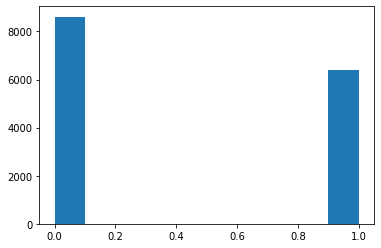

In [ ]:
model_r = catboost.CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=16, l2_leaf_reg=100, task_type="GPU")
model_r.fit(x_train, y_train['target_r'], eval_set=(x_test, y_test['target_r']), verbose=True)
test_model(model_r, x_test, y_test['target_r'])

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
5013:	learn: 0.2338471	test: 0.4100288	best: 0.4100104 (5011)	total: 11m 48s	remaining: 11m 44s
5014:	learn: 0.2338324	test: 0.4100283	best: 0.4100104 (5011)	total: 11m 48s	remaining: 11m 44s
5015:	learn: 0.2338019	test: 0.4100179	best: 0.4100104 (5011)	total: 11m 48s	remaining: 11m 44s
5016:	learn: 0.2337839	test: 0.4100266	best: 0.4100104 (5011)	total: 11m 48s	remaining: 11m 44s
5017:	learn: 0.2337698	test: 0.4100358	best: 0.4100104 (5011)	total: 11m 49s	remaining: 11m 43s
5018:	learn: 0.2337524	test: 0.4100465	best: 0.4100104 (5011)	total: 11m 49s	remaining: 11m 43s
5019:	learn: 0.2337203	test: 0.4100635	best: 0.4100104 (5011)	total: 11m 49s	remaining: 11m 43s
5020:	learn: 0.2337017	test: 0.4100720	best: 0.4100104 (5011)	total: 11m 49s	remaining: 11m 43s
5021:	learn: 0.2336515	test: 0.4100256	best: 0.4100104 (5011)	total: 11m 49s	remaining: 11m 43s
5022:	learn: 0.2336145	test: 0.4100339	best: 0.4100104 (50

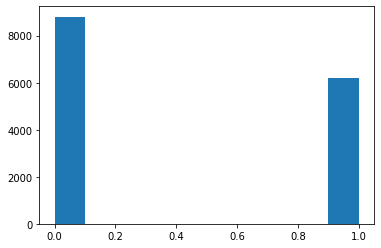

In [ ]:
model_g = catboost.CatBoostClassifier(iterations=10000, learning_rate=0.08, depth=12, l2_leaf_reg=100, task_type="GPU",)
model_g.fit(x_train, y_train['target_g'], eval_set=(x_test, y_test['target_g']), verbose=True)
test_model(model_g, x_test, y_test['target_g'])

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
7013:	learn: 0.1508088	test: 0.3755624	best: 0.3755624 (7013)	total: 16m 42s	remaining: 11m 52s
7014:	learn: 0.1507929	test: 0.3755648	best: 0.3755624 (7013)	total: 16m 42s	remaining: 11m 52s
7015:	learn: 0.1507822	test: 0.3755614	best: 0.3755614 (7015)	total: 16m 42s	remaining: 11m 52s
7016:	learn: 0.1507517	test: 0.3755459	best: 0.3755459 (7016)	total: 16m 42s	remaining: 11m 51s
7017:	learn: 0.1507347	test: 0.3755549	best: 0.3755459 (7016)	total: 16m 42s	remaining: 11m 51s
7018:	learn: 0.1507149	test: 0.3755674	best: 0.3755459 (7016)	total: 16m 42s	remaining: 11m 51s
7019:	learn: 0.1507011	test: 0.3755704	best: 0.3755459 (7016)	total: 16m 43s	remaining: 11m 51s
7020:	learn: 0.1506771	test: 0.3755409	best: 0.3755409 (7020)	total: 16m 43s	remaining: 11m 51s
7021:	learn: 0.1506642	test: 0.3755647	best: 0.3755409 (7020)	total: 16m 43s	remaining: 11m 51s
7022:	learn: 0.1506505	test: 0.3755631	best: 0.3755409 (70

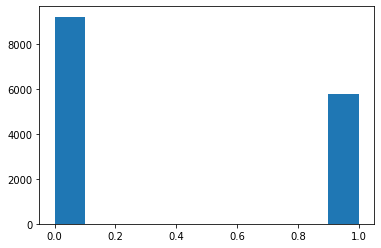

In [ ]:
model_b = catboost.CatBoostClassifier(iterations=12000, learning_rate=0.06, depth=12, l2_leaf_reg=30, task_type="GPU",)
model_b.fit(x_train, y_train['target_b'], eval_set=(x_test, y_test['target_b']), verbose=True)
test_model(model_b, x_test, y_test['target_b'])

In [ ]:
features_test = trans.fit_transform(test)
print(features_test.shape)

result = pd.DataFrame()
result['target_r'] = model_r.predict(features_test)
result['target_g'] = model_g.predict(features_test)
result['target_b'] = model_b.predict(features_test)
result.to_csv('result.csv', index=False)

(39924, 496)


In [ ]:
print(x_train)
print(y_train)

        Feature_23_adv_cv_enum_0  Feature_23_adv_cv_enum_1  \
93629                  -0.304533                 -0.145602   
321542                 -0.304533                 -0.145602   
99247                  -0.304533                 -0.145602   
159588                 -0.304533                 -0.145602   
337882                 -0.304533                 -0.145602   
...                          ...                       ...   
7852                   -0.304533                 -0.145602   
245109                  3.283701                 -0.145602   
199545                 -0.304533                 -0.145602   
6964                   -0.304533                 -0.145602   
123745                 -0.304533                 -0.145602   

        Feature_23_adv_cv_enum_2  Feature_23_adv_cv_enum_3  \
93629                  -0.379138                 -0.412715   
321542                 -0.379138                 -0.412715   
99247                  -0.379138                 -0.412715   
159588 

In [ ]:
import tensorflow as tf
# class_weights = {
#     0: 0.40,
#     1: 0.60
# }
keras_log = tf.keras.models.Sequential([
    tf.keras.layers.Dense(1000, activation='sigmoid', input_shape=(x_train.shape[1],)),
    tf.keras.layers.Dense(500, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(3, activation='sigmoid'),
])
keras_log.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy', tf.keras.metrics.Precision(name="precision")])
keras_log.summary()
history = keras_log.fit(x=x_train[:10000], y=y_train[:10000], batch_size=2, epochs=100, shuffle=True)
# test_model(keras_log, x_test, y_test)
plt.plot(history.history['binary_accuracy'], label="Accuracy")
# plt.plot(history.history['val_binary_accuracy'], label="Val accuracy")
# plt.plot(history.history['precision'], label="Precision")
# plt.plot(history.history['val_precision'], label="Val precision")
plt.legend()
plt.show()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_35 (Dense)             (None, 1000)              31000     
_________________________________________________________________
dense_36 (Dense)             (None, 500)               500500    
_________________________________________________________________
dense_37 (Dense)             (None, 200)               100200    
_________________________________________________________________
dense_38 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_39 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_40 (Dense)             (None, 3)                 153       
Total params: 657,003
Trainable params: 657,003
Non-trainable params: 0
________________________________________________

KeyboardInterrupt: ignored